# The Limits of Machine Learning

## Background

One core problem of contemporary machine learning techniques, as pointed out by [Marcus 2017], [Lake et. al. 2017], and many others, is a lack of symbolic reasoning skills in purely statistically trained ("deep learning" type) models like convolutional neural networks. While [Lake et. al. 2017] propose many possible technological fixes for this problem (for instance, the integration of a game-engine style physics model into a network), we could ask with [Agre 1995] if these fixes do not simply defer an inherently philosophical problem: the problem that, despite neural networks being general function approximators, intelligent generalization can not be modeled with general function approximation. As [Marcus 2017] writes: 

> The real problem lies in misunderstanding what deep learning is, and is not, good for. The technique excels at solving closed-end classification problems, in which a wide range of potential signals must be mapped onto a limited number of categories, given that there is enough data available and the test set closely resembles the training set.
But deviations from these assumptions can cause problems; deep learning is just a statistical technique, and all statistical techniques suffer from deviation from their assumptions.

In other words, "true" generalization would be closer to Cartesian compositionality then just a very large mapping betwen domains. Again [Marcus 2017]:

> [S]ome problems cannot, given real- world limitations, be thought of as classification problems at all. Open-ended natural language understanding, for example, should not be thought of as a classifier mapping between a large finite set of sentences and large, finite set of sentences, but rather a mapping between a potentially infinite range of input sentences and an equally vast array of meanings, many never previously encountered. In a problem like that, deep learning becomes a square peg slammed into a round hole, a crude approximation when there must be a solution elsewhere.

As an illustration of his argument, [Marcus 2017] proposes a toy example: generalizing from even to odd numbers:

> Distilling the broad-ranging problems of language down to a simple example that I believe still has resonance now, I ran a series of experiments in which I trained three- layer perceptrons (fully connected in today’s technical parlance, with no convolution) on the identity function, $f(x) = x$, e.g, $f(12)=12$.

The technical setup for the experiment is simple:

> 1997-vintage networks were, to be sure, simpler than current models — they used no more than three layers (inputs nodes connected to hidden nodes connected to outputs node), and lacked Lecun’s powerful convolution technique. But they were driven by backpropagation just as today’s systems are, and just as beholden to their training data.

The results are straightforward:

> Every time I ran the experiment, using a wide variety of parameters, the results were the same: the network would (unless it got stuck in local minimum) correctly apply the identity function to the even numbers that it had seen before (say 2, 4, 8 and 12), and to some other even numbers (say 6 and 14) but fail on all the odds numbers, yielding, for example f(15) = 14. [...] Odd numbers were outside the training space, and the networks could not generalize identity outside that space. Adding more hidden units didn’t help, and nor did adding more hidden layers. Simple multilayer perceptrons simply couldn’t generalize outside their training space [...].

## Reproducing the experiment

In the following, we will reproduce the experiment described in [Marcus:2017]. The intention behind this is not so much the validation of his results but an excercise in critical technical practice ([Agre 1997]), in translating between philosophical and technical contexts. Additionally, given the availability of tools compared to 1997, we can implement some simple variations of the proposed experiment (more layers, different structures, etc.), and potentially show that the results still hold. 

## Imports
To be able to use mechanisms like differentiation and backpropagation we need a high-level library that abstracts these mathematical details away from us. We are using Keras, the de-facto standard for high-level prototyping for machine learning. Keras is a front-end to the Tensorflow framework, which is one of the ost widely used machine learning frameworks (for a comparison, see machine learning frameworks). Because we are operating in high-dimensional vectir space (and because Keras/Tensorflow use its datatypes), we are also using Numpy, the Python library for scientific computing. Finally, we are importing a single helper function from Scipy to split our data into train and test sets, and some helper functions to plot our activation functions.

In [1]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

/home/fabian/anaconda3/envs/py36-phd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Settings

These constants are the hyperparameters for our neural network. Exactly as proposed by [Marcus 2017], we are implementing the identity function $f(x) = x$ for binary integers. Our parameters are:

- Our integers have `BITS` bits, so our network should learn to apply the identify function for $\frac{2^{16}}{2}$ possible *even* integers.
- After training we will test our network on `VAL` validation samples that are kept back.
- Our hidden layers consist of `HIDDEN` units each.
- We use `LAYERS` layers total.
- We train the network for `EPOCHS` "epochs". One epoch is a complete "run" of all available training samples, i.e. a single forward and backward pass with all available samples.
- We pass the samples to the network in batches of `BATCHES` each, this saves memory.
- We do integrate some dropout layers to prevent overfitting (particularly important in this case).
- Finally we "mix in" `MIX` odd numbers into our even numbers to find the threshold that enables the network to generalize for even and odd numbers.

In [2]:
BITS = 16
VAL = 100
HIDDEN = 128
LAYERS = 3
EPOCHS = 1000
BATCHES = 128
DROPOUT = True
MIX = 20

## Function to approximate

We define the most simple function possible, the identity function $f(x) = x$. To allow some additional experiments, we also define the bitwise-not function, $f(x)=\sim{x}$. Note that the numpy implementation of bitwise not returns an array of truth values. To convert this into an array of 0s and 1s, we simply multiply it by 1.

In [3]:
def f(x):
    
    # Identity
    return x
    
    # Bitwise not
    # return  np.logical_not(x) * 1

## Creating the training data

Our training data is simple: a set of binary values, encoded as `BITS` dimensional vectors (e.g. `[0, 0, 1, 1, 1]`), provides both the input and desired output of our network. To produce this set, we create two two-dimensional arrays (`x_even` and `x_odd`) that will hold the even and odd numbers, respectively. We then fill the arrays from the bottom up, by iterating over the range of all $2^{\text{BITS}}$ possible numbers with a step width of 2. In each step, we write the current number to the array that holds the even numbers, and the current number minus one to the array that holds the odd numbers. We randomly shuffle both arrays, and reserve a part for testing, and another (smaller) part for validation. Finally, we apply the function defined above to a copy of the array of even numbers, and use this as the target.

In [4]:
MAX = 2**BITS # BITS bits = 2^BITS values

# Make space for all even BITS-bit numbers and all odd BITS-bit numbers
x_even = np.zeros((int(MAX/2), BITS), dtype=int)
x_odd = np.zeros((int(MAX/2), BITS), dtype=int)

# Fill from the bottom, converting to binary on the fly
for i in range(0, MAX, 2):
    x_even[int(i/2),:] = np.array(list(np.binary_repr(i, BITS)))
    x_odd[int(i/2),:] = np.array(list(np.binary_repr(i+1, BITS)))

# Randomly shuffle everything    
np.random.shuffle(x_even)
np.random.shuffle(x_odd)

x_val_even = x_even[-VAL:,:] # Save last VAL random even numbers for prediction 
x_even = x_even[:-VAL,:] # (use the rest for training and testing)
x_val_odd = x_odd[-VAL:,:] # Save last VAL random odd numbers for prediction (throw the rest away)

x_even[:MIX,:] = x_odd[:MIX,:]
# Randomly shuffle again   
np.random.shuffle(x_even)

# Apply function we would like to model
y = f(x_even)

# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_train, x_test, y_train, y_test = train_test_split(x_even, y, test_size=0.1, random_state=42)

print(str(BITS) + ' bit numbers = ' + str(MAX) + ' possible values.')
print("Train set: " + str(len(x_train)) + ' even binary vectors (' + str(MIX) + ' odd mixed into total set).')
print("Test set: " + str(len(x_test)) + ' even binary vectors (' + str(MIX) + ' odd mixed into total set).')
print("Validation set: " + str(len(x_val_even)) + ' even binary vectors and ' + str(len(x_val_odd)) + ' odd binary vectors.')

16 bit numbers = 65536 possible values.
Train set: 29401 even binary vectors (20 odd mixed into total set).
Test set: 3267 even binary vectors (20 odd mixed into total set).
Validation set: 100 even binary vectors and 100 odd binary vectors.


## Building the model

Keras conveniently provides us with abstractions for many of the most commonly used building blocks of neural networks. For this experiment, we are using six different components: fully connected layers, ReLu activation, a sigmoid activation, a binary cross-entropy loss function, and backporpagation by means of stochastic gradient descent.

### Fully connected layer

This is the standard, multilayer perceptron layer, where every unit of a layer is connected to every unit of the layer before and after. 

### ReLu activation function

[Rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) are the most popular neural network units at the time of writing. Despite their "linear look", the [activation function](https://en.wikipedia.org/wiki/Activation_function) used: 

$$f(x)=\max(0,x)$$

is actually nonlinear ([piecewise-linear](https://en.wikipedia.org/wiki/Piecewise_linear_function), to be precise) *and* differentiable. Why nonlinear? Well, a linear function has to satisfy the condition 

$$\forall_{x,y}: f(x) + f(y) = f(x+y)$$

For ReLu, 

$$f(-1) = -1$$
$$f(1) = 1$$
$$f(0) = 0$$ 

Its derivative is then simply 

$$f'(x)={\begin{cases}0&{\text{for }}x<0\\1&{\text{for }}x\geq 0\end{cases}}$$

Interestingly, the "almost-linearity" of ReLus does not impede their universality in approximating functions (see [these examples](https://www.quora.com/Is-a-single-layered-ReLu-network-still-a-universal-approximator/answer/Conner-Davis-2)).

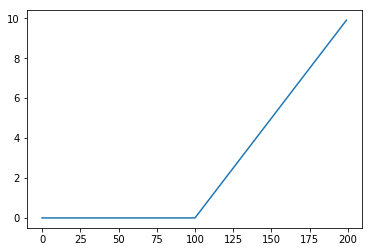

In [5]:
plt.plot([max(0, x) for x in np.arange(-10.0,10.0,0.1)])
plt.show()

### Sigmoid activation function

The [sigmoid function](https://en.wikipedia.org/wiki/Logistic_function), also called logistic function, looks roughly like the simple step function but has non-zero gradients everywhere, which makes it fully differentiable. It is defined as

$$f(x)={\frac {1}{1+e^{-x}}}$$

with the derivative

$$f'(x)=f(x)(1-f(x))$$

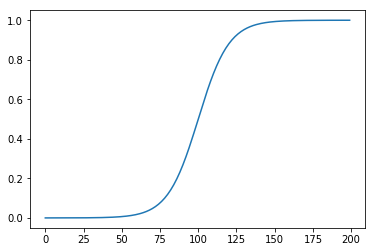

In [6]:
plt.plot([sigmoid(x) for x in np.arange(-10.0,10.0,0.1)])
plt.show()

### Binary cross-entopy loss function

Because our input and output are binary numbers, we are dealing with a multi-label classification problem. The loss function best suited to address this scenario is binary [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy). In mathematical terms, minimizing this function equals minimizing the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), here the divergence of the probability distribution inherent in the training set and the probability distribution created by the model.

### Backpropagation via stochastic gradient descent

[...]

In [7]:
model = Sequential()
# Dense(HIDDEN) is a fully-connected layer with HIDDEN hidden units.
# In the first layer, you must specify the expected input data shape, here BITS-dimensional vectors.
model.add(layers.Dense(HIDDEN, activation='relu', input_dim=BITS))
for _ in range(LAYERS-1):
    model.add(layers.Dense(HIDDEN, activation='relu'))
    if (DROPOUT): model.add(layers.Dropout(0.5))
# Sigmoid activation for multilabel classification
# https://github.com/keras-team/keras/issues/741
# https://en.wikipedia.org/wiki/Multi-label_classification
model.add(layers.Dense(BITS, activation='sigmoid'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Binary crossentropy for multilabel classification
# https://github.com/keras-team/keras/issues/741
# https://en.wikipedia.org/wiki/Multi-label_classification
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
Total params: 37,264
Trainable params: 37,264
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [8]:
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCHES)
score = model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/1000
29401/29401 [==============================] - 1s 44us/step - loss: 0.6590 - acc: 0.5837
Epoch 2/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.6022 - acc: 0.6648
Epoch 3/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.5444 - acc: 0.7247
Epoch 4/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.4895 - acc: 0.7657
Epoch 5/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.4422 - acc: 0.7946
Epoch 6/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.4029 - acc: 0.8169
Epoch 7/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.3733 - acc: 0.8332
Epoch 8/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.3478 - acc: 0.8465
Epoch 9/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.3280 - acc: 0.8557
Epoch 10/1000
29401/29401 [==============================] - 0s 12us/step - loss: 

29401/29401 [==============================] - 0s 12us/step - loss: 0.1681 - acc: 0.9317
Epoch 79/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1678 - acc: 0.9319
Epoch 80/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1671 - acc: 0.9323
Epoch 81/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1656 - acc: 0.9330
Epoch 82/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1643 - acc: 0.9340
Epoch 83/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1641 - acc: 0.9337
Epoch 84/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1634 - acc: 0.9338
Epoch 85/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1621 - acc: 0.9348
Epoch 86/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1619 - acc: 0.9355
Epoch 87/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.160

29401/29401 [==============================] - 0s 14us/step - loss: 0.1232 - acc: 0.9533
Epoch 158/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.1233 - acc: 0.9533
Epoch 159/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.1239 - acc: 0.9530
Epoch 160/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.1226 - acc: 0.9536
Epoch 161/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.1221 - acc: 0.9538
Epoch 162/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.1217 - acc: 0.9542
Epoch 163/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.1212 - acc: 0.9540
Epoch 164/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1212 - acc: 0.9544
Epoch 165/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.1211 - acc: 0.9543
Epoch 166/1000
29401/29401 [==============================] - 0s 12us/step - lo

29401/29401 [==============================] - 0s 12us/step - loss: 0.0923 - acc: 0.9668
Epoch 236/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0931 - acc: 0.9663
Epoch 237/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0927 - acc: 0.9666
Epoch 238/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0933 - acc: 0.9667
Epoch 239/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0937 - acc: 0.9661
Epoch 240/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0917 - acc: 0.9670
Epoch 241/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0923 - acc: 0.9669
Epoch 242/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0912 - acc: 0.9674
Epoch 243/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0915 - acc: 0.9672
Epoch 244/1000
29401/29401 [==============================] - 0s 12us/step - lo

29401/29401 [==============================] - 0s 12us/step - loss: 0.0722 - acc: 0.9757
Epoch 314/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0706 - acc: 0.9763
Epoch 315/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0716 - acc: 0.9757
Epoch 316/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0717 - acc: 0.9756
Epoch 317/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0716 - acc: 0.9757
Epoch 318/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0698 - acc: 0.9764
Epoch 319/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0710 - acc: 0.9759
Epoch 320/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0700 - acc: 0.9766
Epoch 321/1000
29401/29401 [==============================] - 0s 14us/step - loss: 0.0702 - acc: 0.9761
Epoch 322/1000
29401/29401 [==============================] - 0s 13us/step - lo

29401/29401 [==============================] - 0s 13us/step - loss: 0.0577 - acc: 0.9820
Epoch 392/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0582 - acc: 0.9816
Epoch 393/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0579 - acc: 0.9821
Epoch 394/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0579 - acc: 0.9819
Epoch 395/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0577 - acc: 0.9820
Epoch 396/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0568 - acc: 0.9822
Epoch 397/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0571 - acc: 0.9823
Epoch 398/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0562 - acc: 0.9825
Epoch 399/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0564 - acc: 0.9826
Epoch 400/1000
29401/29401 [==============================] - 0s 13us/step - lo

29401/29401 [==============================] - 0s 12us/step - loss: 0.0497 - acc: 0.9855
Epoch 470/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0495 - acc: 0.9851
Epoch 471/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0494 - acc: 0.9853
Epoch 472/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0491 - acc: 0.9854
Epoch 473/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0495 - acc: 0.9852
Epoch 474/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0491 - acc: 0.9854
Epoch 475/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0482 - acc: 0.9858
Epoch 476/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0492 - acc: 0.9853
Epoch 477/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0483 - acc: 0.9856
Epoch 478/1000
29401/29401 [==============================] - 0s 12us/step - lo

29401/29401 [==============================] - 0s 12us/step - loss: 0.0448 - acc: 0.9869
Epoch 548/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0452 - acc: 0.9869
Epoch 549/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0454 - acc: 0.9869
Epoch 550/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0445 - acc: 0.9872
Epoch 551/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0452 - acc: 0.9869
Epoch 552/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0438 - acc: 0.9874
Epoch 553/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0449 - acc: 0.9870
Epoch 554/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0445 - acc: 0.9872
Epoch 555/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0442 - acc: 0.9872
Epoch 556/1000
29401/29401 [==============================] - 0s 12us/step - lo

29401/29401 [==============================] - 0s 12us/step - loss: 0.0428 - acc: 0.9878
Epoch 626/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0425 - acc: 0.9877
Epoch 627/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0414 - acc: 0.9882
Epoch 628/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0422 - acc: 0.9879
Epoch 629/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0421 - acc: 0.9881
Epoch 630/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0420 - acc: 0.9880
Epoch 631/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0431 - acc: 0.9877
Epoch 632/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0417 - acc: 0.9880
Epoch 633/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0421 - acc: 0.9880
Epoch 634/1000
29401/29401 [==============================] - 0s 12us/step - lo

29401/29401 [==============================] - 0s 12us/step - loss: 0.0405 - acc: 0.9885
Epoch 704/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0408 - acc: 0.9883
Epoch 705/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0399 - acc: 0.9885
Epoch 706/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0405 - acc: 0.9886
Epoch 707/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0407 - acc: 0.9885
Epoch 708/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0409 - acc: 0.9884
Epoch 709/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0401 - acc: 0.9885
Epoch 710/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0409 - acc: 0.9883
Epoch 711/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0401 - acc: 0.9886
Epoch 712/1000
29401/29401 [==============================] - 0s 12us/step - lo

29401/29401 [==============================] - 0s 13us/step - loss: 0.0387 - acc: 0.9892
Epoch 782/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0387 - acc: 0.9891
Epoch 783/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0394 - acc: 0.9889
Epoch 784/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0398 - acc: 0.9888
Epoch 785/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0396 - acc: 0.9889
Epoch 786/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0390 - acc: 0.9892
Epoch 787/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0395 - acc: 0.9888
Epoch 788/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0391 - acc: 0.9889
Epoch 789/1000
29401/29401 [==============================] - 0s 13us/step - loss: 0.0383 - acc: 0.9894
Epoch 790/1000
29401/29401 [==============================] - 0s 13us/step - lo

29401/29401 [==============================] - 0s 12us/step - loss: 0.0380 - acc: 0.9896
Epoch 860/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0381 - acc: 0.9895
Epoch 861/1000
29401/29401 [==============================] - 0s 14us/step - loss: 0.0389 - acc: 0.9894
Epoch 862/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0381 - acc: 0.9895
Epoch 863/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0384 - acc: 0.9894
Epoch 864/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0383 - acc: 0.9894
Epoch 865/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0384 - acc: 0.9894
Epoch 866/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0385 - acc: 0.9895
Epoch 867/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0378 - acc: 0.9896
Epoch 868/1000
29401/29401 [==============================] - 0s 12us/step - lo

29401/29401 [==============================] - 0s 13us/step - loss: 0.0374 - acc: 0.9900
Epoch 938/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0382 - acc: 0.9897
Epoch 939/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0376 - acc: 0.9898
Epoch 940/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0375 - acc: 0.9899
Epoch 941/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0376 - acc: 0.9898
Epoch 942/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0378 - acc: 0.9898
Epoch 943/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0381 - acc: 0.9898
Epoch 944/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0379 - acc: 0.9899
Epoch 945/1000
29401/29401 [==============================] - 0s 12us/step - loss: 0.0375 - acc: 0.9898
Epoch 946/1000
29401/29401 [==============================] - 0s 12us/step - lo

## Evaluating the model

We are now using the samples that we kept back to evaulate how well our model has learned to approximate the identity function. First, we define some "pretty printing" options, then we let our model make predictions and compare the evaluation samples with the outputs of the prediction, digit by digit.

In [9]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

x_pred_even = np.rint(model.predict(x_val_even)).astype(np.uint8)
x_pred_odd = np.rint(model.predict(x_val_odd)).astype(np.uint8)

print('EVEN\n')
for y in range(VAL):
    for x in range(BITS):
        if f(x_val_even)[y, x] == x_pred_even[y, x]:
            print(colors.ok + str(x_pred_even[y, x]) + colors.close, end=' ')
        else:
            print(colors.fail + str(x_pred_even[y, x]) + colors.close, end=' ')
    # https://stackoverflow.com/questions/41069825/convert-binary-01-numpy-to-integer-or-binary-string#41069967
    print(x_pred_even[y,:].dot(2**np.arange(x_pred_even[y,:].size)[::-1]))

print('\nODD\n')
for y in range(VAL):
    for x in range(BITS):
        if f(x_val_odd)[y, x] == x_pred_odd[y, x]:
            print(colors.ok + str(x_pred_odd[y, x]) + colors.close, end=' ')
        else:
            print(colors.fail + str(x_pred_odd[y, x]) + colors.close, end=' ')
    # https://stackoverflow.com/questions/41069825/convert-binary-01-numpy-to-integer-or-binary-string#41069967
    print(x_pred_odd[y,:].dot(2**np.arange(x_pred_odd[y,:].size)[::-1]))

EVEN

1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 50312
0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 30040
1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 49972
1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 61866
0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 3512
0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 11988
0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 25058
1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 47692
1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 51042
0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 17118
0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 10932
0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 21106
1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 55104
1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 53264
0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 15854
0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 24010
0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 25228
1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 39754
0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 20670
0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 7670
0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 20972
1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 34576
0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 13896
1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 59606
1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 57278
0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 16950
1 0 1 1 

0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 16618
0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 19318
1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 64824
0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 16570
1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 44294
1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 48784
1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 41674
1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 32836
1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 38816
1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 44152
0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 28422
1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 51282
1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 53536
0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 4370
1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 38162
0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 8126
1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 36638
0 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 14772
1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 37250
1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 64028
1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 54138
0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 25038
0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 17306
1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 39234
1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 64238
1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 39926
0 1 0 0 1 0 0 

1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 54470
0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 16588
0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 19022
0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 14134
0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 13976
1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 33122
0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 18000
0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 25982
1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 40256
1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 63860
0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 594
1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 36480
1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 38808
1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 42944
1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 57108
1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 52904
1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 48710
0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 26714
0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 30632
0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 2404
1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 57038
0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 28112
0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 30422
0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 22350
0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 17618
0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 30108
1 0 0 1 0 1 1 1

## Bibliography

- Agre, Philip E. *Computation and Human Experience*. Cambridge University Press, 1997.
- Agre, Philip E. "The Soul Gained and Lost. Artificial Intelligence as a Philosophical Project." Stanford Humanities Review 4, no. 2 (1995): 1–19.
- Hornik, Kurt, Maxwell Stinchcombe, and Halbert White. "Multilayer Feedforward Networks Are Universal Approximators." Neural Networks 2, no. 5 (1989): 359–66.
- Lake, Brenden M., Tomer D. Ullman, Joshua B. Tenenbaum, and Samuel J. Gershman. "Building Machines That Learn and Think Like People." Behavioral and Brain Sciences 40 (2017).
- Marcus, Gary. "Deep Learning: A Critical Appraisal." arXiv Preprint arXiv:1801.00631, 2018. https://arxiv.org/abs/1801.00631v1.